In [63]:
import torch
import pandas as pd
from medgemma_wrapper import MedGemmaQAWrapper
from medical_tokenshap import MedicalTokenSHAP
from TokenSHAP.token_shap import StringSplitter
from TokenSHAP.base import TfidfTextVectorizer

import random
import numpy as np

def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MedGemmaQAWrapper("google/medgemma-4b-it", device=str(device))
splitter = StringSplitter()
token_shap = MedicalTokenSHAP(model=model, splitter=splitter)
token_shap.vectorizer = TfidfTextVectorizer()

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


In [3]:
def sample_range(df, lo, hi, k=3, seed=42):
    """
    Return up to k random samples where the 'question' column
    has between lo and hi words (inclusive).
    Does NOT modify the original dataframe.
    """
    # Compute word counts temporarily
    word_counts = df["question"].str.split().str.len()
    mask = (word_counts >= lo) & (word_counts <= hi)
    subset = df.loc[mask]

    if subset.empty:
        print(f"[Info] No samples found for range {lo}-{hi} words.")
        return pd.DataFrame()
    
    return subset.sample(min(k, len(subset)), random_state=seed).reset_index(drop=True)

In [21]:
mcq_df = pd.read_parquet("mcq_df.parquet", engine='fastparquet').reset_index(drop=True)
yn_df = pd.read_parquet("yn_df.parquet", engine='fastparquet').reset_index(drop=True)

# Select samples where question length is reasonably short for quicker TokenSHAP
yn_short   = sample_range(yn_df,  10, 18, k=10)
mcq_mid    = sample_range(mcq_df, 21, 60, k=10)


In [5]:
yn_short.head(3)

,dataset_name,id_in_dataset,question,options,answer_label,question_type,prompt_text
0,pubmedqa,985,Does septoplasty change the dimensions of comp...,Answer Choices:\nA. Yes\nB. No,no,Y/N,Question:\nDoes septoplasty change the dimensi...
1,pubmedqa,198,Transesophageal echocardiographic assessment o...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nTransesophageal echocardiographic a...
2,pubmedqa,447,Chemoradiotherapy in the management of locally...,Answer Choices:\nA. Yes\nB. No,no,Y/N,Question:\nChemoradiotherapy in the management...


In [22]:
for i in range(10):
    print(yn_short.loc[i, "question"])
    print()

Does septoplasty change the dimensions of compensatory hypertrophy of the middle turbinate?

Transesophageal echocardiographic assessment of left ventricular function in brain-dead patients: are marginally acceptable hearts suitable for transplantation?

Chemoradiotherapy in the management of locally advanced squamous cell carcinoma esophagus: is surgical resection required?

Are even impaired fasting blood glucose levels preoperatively associated with increased mortality after CABG surgery?

Scrotal approach to both palpable and impalpable undescended testes: should it become our first choice?

Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention?

Advanced epithelial ovarian carcinoma in Thai women: should we continue to offer second-look laparotomy?

Clinical identifiers for early-stage primary/idiopathic adhesive capsulitis: are we seeing the real picture?

The effective orifice area/patient aortic annulus area ratio: a better way 

In [6]:
yn_short.loc[0, "question"]

'Does septoplasty change the dimensions of compensatory hypertrophy of the middle turbinate?'

In [7]:
yn_short.loc[0, "options"]

'Answer Choices:\nA. Yes\nB. No'

In [8]:
yn_short.loc[0, "answer_label"]

'no'

In [9]:
print(yn_short.loc[0, "prompt_text"])

Question:
Does septoplasty change the dimensions of compensatory hypertrophy of the middle turbinate?

Answer Choices:
A. Yes
B. No


In [25]:
yn_sample = yn_short.iloc[5]
mcq_sample = mcq_mid.iloc[0]


In [26]:
print(yn_sample["question"])

Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention?


In [12]:
print(mcq_sample["question"])

A 9 year old girl was admited for dialysis. On laboratory examination her potassium levels were 7.8 mEq/L. Which of the following would quickly lower her increased potassium levels -


In [27]:
model.set_task("yn")
model.set_mode("answer_rationale")

In [28]:
yn_prompt = yn_sample["prompt_text"]
print(yn_prompt)

Question:
Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention?

Answer Choices:
A. Yes
B. No


In [61]:
print("=" * 80)
print("YES/NO SAMPLE (iloc=0)")
print("=" * 80)
answer_map = {'A': 'yes', 'B': 'no'}

model.set_task("yn")
yn_gt = yn_sample["answer_label"]

# Get full output with rationale
yn_full = model.generate(yn_prompt)

# Get confidence scores
yn_answer, yn_conf, yn_probs = model.generate_with_confidence(yn_prompt)

print(f"PROMPT:\n{yn_prompt}\n")
print(f"GROUND TRUTH: {yn_gt}")
print("-" * 80)
print(f"FULL OUTPUT:\n{yn_full}")
print("-" * 80)
print(f"ANSWER: {yn_answer}")
print(f"CONFIDENCE: {yn_conf:.3f} ({yn_conf*100:.1f}%)")
print(f"PROBABILITIES: P(A)={yn_probs['A']:.3f}, P(B)={yn_probs['B']:.3f}")
print(f"CORRECT: {'✓' if answer_map[yn_answer] == yn_gt else '✗'}")



YES/NO SAMPLE (iloc=0)
PROMPT:
Question:
Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention?

Answer Choices:
A. Yes
B. No

GROUND TRUTH: no
--------------------------------------------------------------------------------
FULL OUTPUT:
Answer: A
Rationale: Aspiration thrombectomy (AT) has been shown to be beneficial in patients undergoing primary percutaneous coronary intervention (PCI) for acute myocardial infarction (AMI), particularly in those with a high thrombus burden. Studies have demonstrated that AT can improve clinical outcomes, including reduced rates of major adverse cardiovascular events (MACE), such as death, re-infarction, and stroke. AT is typically performed in patients with a high thrombus burden, as determined by visual assessment during PCI, and is often used in conjunction with antithrombotic therapy.
--------------------------------------------------------------------------------
ANSWER: A
CONFIDENCE: 0.963 (96.3

In [34]:
model.set_task("yn")

# Define mapping
answer_map = {'A': 'yes', 'B': 'no'}
results = []

for i in range(len(yn_short)):
    prompt = yn_short.loc[i, "prompt_text"]
    ground_truth = yn_short.loc[i, "answer_label"].lower()  # normalize to lowercase
    
    answer, conf, probs = model.generate_with_confidence(prompt)
    answer_text = answer_map[answer]  # Convert A/B to yes/no
    correct = (answer_text == ground_truth)
    
    results.append({
        'answer': answer,
        'answer_text': answer_text,
        'confidence': conf,
        'correct': correct,
        'probs': probs
    })
    
    # Only show wrong answers or low confidence
    if not correct:
        print(f"Q{i+1:2d}: {answer_text} → {ground_truth} ✗  \t[conf: {conf:.1%}]")
    elif conf < 0.6:
        print(f"Q{i+1:2d}: {answer_text} ✓ (LOW) \t[conf: {conf:.1%}]")
    else:
        print(f"Q{i+1:2d}: {answer_text} ✓ \t\t[conf: {conf:.1%}]")

print(f"\n{'='*50}")
avg_conf = sum(r['confidence'] for r in results) / len(results)
accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Results: {sum(r['correct'] for r in results)}/{len(results)} correct ({accuracy:.1%})")
print(f"Avg confidence: {avg_conf:.1%}")

Q 1: yes → no ✗  	[conf: 52.6%]
Q 2: yes ✓ 		[conf: 76.8%]
Q 3: no ✓ 		[conf: 99.8%]
Q 4: yes ✓ 		[conf: 97.8%]
Q 5: no → yes ✗  	[conf: 99.6%]
Q 6: yes → no ✗  	[conf: 96.3%]
Q 7: no ✓ 		[conf: 87.4%]
Q 8: no ✓ 		[conf: 99.6%]
Q 9: yes ✓ 		[conf: 94.1%]
Q10: yes ✓ 		[conf: 87.0%]

Results: 7/10 correct (70.0%)
Avg confidence: 89.1%


In [40]:
print(yn_prompt)

Question:
Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention?

Answer Choices:
A. Yes
B. No


In [42]:
df = token_shap.analyze(
    prompt=yn_prompt,
    sampling_ratio=0.4,
    max_combinations=60,      
    print_highlight_text=True 
)

Processing combinations: 100%|██████████| 60/60 [04:08<00:00,  4.14s/it]

Is Aspiration Thrombectomy Beneficial in Patients Undergoing Primary Percutaneous Coronary Intervention? 


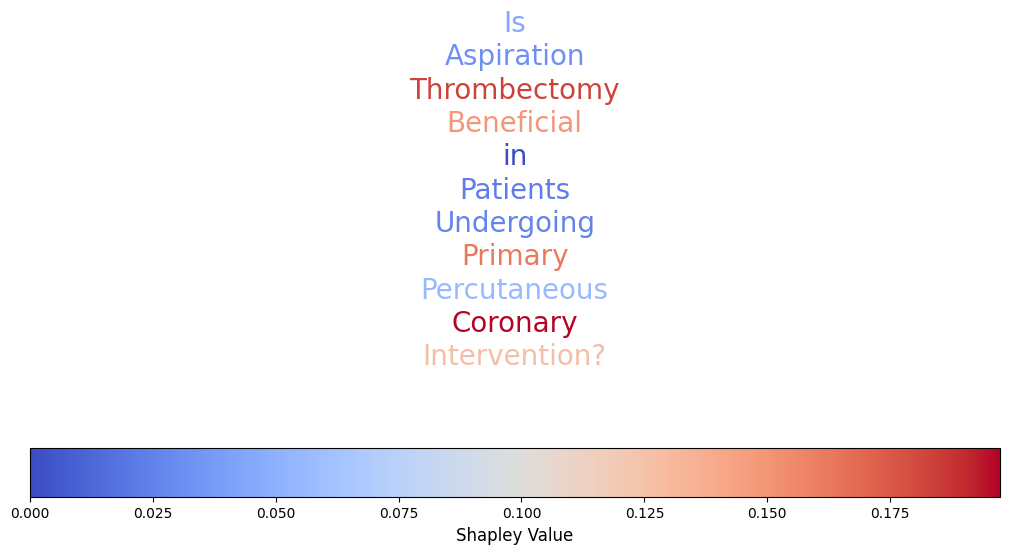

In [43]:
token_shap.plot_colored_text(new_line=True)


In [51]:
yn_very_short = sample_range(yn_df,  9, 13, k=10)
yn_very_short

,dataset_name,id_in_dataset,question,options,answer_label,question_type,prompt_text
0,pubmedqa,150,Are serum leptin levels a prognostic factor in...,Answer Choices:\nA. Yes\nB. No,no,Y/N,Question:\nAre serum leptin levels a prognosti...
1,pubmedqa,481,Blunt trauma in intoxicated patients: is compu...,Answer Choices:\nA. Yes\nB. No,no,Y/N,Question:\nBlunt trauma in intoxicated patient...
2,pubmedqa,331,Profiling quality of care: Is there a role for...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nProfiling quality of care: Is there...
3,pubmedqa,508,Does head positioning influence anterior chamb...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nDoes head positioning influence ant...
4,pubmedqa,724,Some aspects of social exclusion: do they infl...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nSome aspects of social exclusion: d...
5,pubmedqa,530,Is robotically assisted laparoscopic radical p...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nIs robotically assisted laparoscopi...
6,pubmedqa,786,CYP2D6*4 allele and breast cancer risk: is the...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nCYP2D6*4 allele and breast cancer r...
7,pubmedqa,216,Quaternary cytoreductive surgery in ovarian ca...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nQuaternary cytoreductive surgery in...
8,pubmedqa,618,Is extended aortic replacement in acute type A...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nIs extended aortic replacement in a...
9,pubmedqa,919,Is laparoscopic cholecystectomy safe and accep...,Answer Choices:\nA. Yes\nB. No,yes,Y/N,Question:\nIs laparoscopic cholecystectomy saf...


In [52]:
for i in range(len(yn_very_short)):
    print(yn_very_short.loc[i, "question"])

Are serum leptin levels a prognostic factor in advanced lung cancer?
Blunt trauma in intoxicated patients: is computed tomography of the abdomen always necessary?
Profiling quality of care: Is there a role for peer review?
Does head positioning influence anterior chamber depth in pseudoexfoliation syndrome?
Some aspects of social exclusion: do they influence suicide mortality?
Is robotically assisted laparoscopic radical prostatectomy less invasive than retropubic radical prostatectomy?
CYP2D6*4 allele and breast cancer risk: is there any association?
Quaternary cytoreductive surgery in ovarian cancer: does surgical effort still matter?
Is extended aortic replacement in acute type A dissection justifiable?
Is laparoscopic cholecystectomy safe and acceptable as a day case procedure?


In [57]:
yn_sample_very_short = yn_very_short.iloc[9]
yn_prompt_very_short = yn_sample_very_short["prompt_text"]
yn_sample_very_short

dataset_name                                              pubmedqa
id_in_dataset                                                  919
question         Is laparoscopic cholecystectomy safe and accep...
options                             Answer Choices:\nA. Yes\nB. No
answer_label                                                   yes
question_type                                                  Y/N
prompt_text      Question:\nIs laparoscopic cholecystectomy saf...
Name: 9, dtype: object

In [62]:
model.set_task("yn")

answer_map = {'A': 'yes', 'B': 'no'}
yn_vshort_gt = yn_sample_very_short["answer_label"]

# Get full output with rationale
yn_vshort_full = model.generate(yn_prompt_very_short)

# Get confidence scores
yn_vshort_answer, yn_vshort_conf, yn_vshort_probs = model.generate_with_confidence(yn_prompt_very_short)

print(f"PROMPT:\n{yn_prompt_very_short}\n")
print(f"GROUND TRUTH: {yn_vshort_gt}")
print("-" * 80)
print(f"FULL OUTPUT:\n{yn_vshort_full}")
print("-" * 80)
print(f"ANSWER: {yn_vshort_answer}")
print(f"CONFIDENCE: {yn_vshort_conf:.3f} ({yn_vshort_conf*100:.1f}%)")
print(f"PROBABILITIES: P(A)={yn_vshort_probs['A']:.3f}, P(B)={yn_vshort_probs['B']:.3f}")
print(f"CORRECT: {'✓' if answer_map[yn_vshort_answer] == yn_vshort_gt else '✗'}")

PROMPT:
Question:
Is laparoscopic cholecystectomy safe and acceptable as a day case procedure?

Answer Choices:
A. Yes
B. No

GROUND TRUTH: yes
--------------------------------------------------------------------------------
FULL OUTPUT:
Answer: A
Rationale: Laparoscopic cholecystectomy is generally considered safe and acceptable as a day case procedure, provided the patient is fit for surgery, has adequate pain control, and is discharged home within 24 hours. The procedure is typically performed under general anesthesia, and patients are monitored closely in the recovery room. The benefits of a day case procedure, such as reduced hospital stay and faster recovery, often outweigh the risks, especially for patients with uncomplicated cholecystitis.
--------------------------------------------------------------------------------
ANSWER: A
CONFIDENCE: 0.990 (99.0%)
PROBABILITIES: P(A)=0.990, P(B)=0.010
CORRECT: ✓


In [77]:
from scipy.stats import spearmanr
import numpy as np

def shap_stability(token_shap, prompt, combos_list=(20,40,60,100), seeds=(0,1,2)):
    """
    Compute SHAP stability by running TokenSHAP multiple times with different
    combination budgets and seeds, then correlating token importance ranks.
    """

    # First run: maximum combinations → reference ranking
    token_shap.analyze(
        prompt,
        sampling_ratio=1.0,
        max_combinations=max(combos_list)
    )
    
    # Extract values correctly from dict
    ref = np.array(list(token_shap.shapley_values.values()))
    ranks_ref = np.argsort(np.argsort(-ref))   # rank high→low

    results = []
    
    for m in combos_list:
        rhos = []
        for s in seeds:
            set_global_seed(s)
            token_shap.analyze(
                prompt,
                sampling_ratio=1.0,
                max_combinations=m,
            )

            # Extract new SHAP values
            vals = np.array(list(token_shap.shapley_values.values()))
            ranks = np.argsort(np.argsort(-vals))

            # Spearman rank correlation with reference
            rho, _ = spearmanr(ranks_ref, ranks)
            rhos.append(rho)

        results.append((m, np.mean(rhos), np.std(rhos)))

    return results


In [78]:
results = shap_stability(token_shap, yn_prompt_very_short,
                         combos_list=(20, 40, 60, 100),
                         seeds=(0,1,2))

for m, mean_rho, std_rho in results:
    print(f"{m:3d} combinations → mean ρ = {mean_rho:.3f} ± {std_rho:.3f}")

Processing combinations: 100%|██████████| 100/100 [06:57<00:00,  4.17s/it]

 20 combinations → mean ρ = 0.648 ± 0.122
 40 combinations → mean ρ = 0.773 ± 0.096
 60 combinations → mean ρ = 0.806 ± 0.058
100 combinations → mean ρ = 0.791 ± 0.032


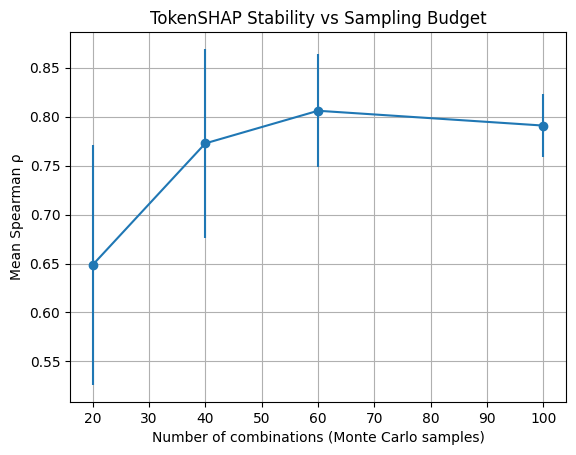

In [79]:
import matplotlib.pyplot as plt

m, mean_rho, std_rho = zip(*results)
plt.errorbar(m, mean_rho, yerr=std_rho, fmt='-o')
plt.xlabel("Number of combinations (Monte Carlo samples)")
plt.ylabel("Mean Spearman ρ")
plt.title("TokenSHAP Stability vs Sampling Budget")
plt.grid(True)
plt.show()

In [82]:
mcq_sample

dataset_name                                               medmcqa
id_in_dataset                                                 7085
question         A 9 year old girl was admited for dialysis. On...
options          Answer Choices:\nA. IV calcium gluconate\nB. I...
answer_label                                                     B
question_type                                                  MCQ
prompt_text      Question:\nA 9 year old girl was admited for d...
Name: 0, dtype: object

In [86]:
mcq_sample_prompt = mcq_sample["prompt_text"]
print(mcq_sample_prompt)

Question:
A 9 year old girl was admited for dialysis. On laboratory examination her potassium levels were 7.8 mEq/L. Which of the following would quickly lower her increased potassium levels -

Answer Choices:
A. IV calcium gluconate
B. IV Glucose and insulin
C. Oral kayexalate in sorbitol
D. IV NaHCO3


In [87]:
model.set_task("mcq")
df = token_shap.analyze(
    prompt=mcq_sample_prompt,
    sampling_ratio=0.4,
    max_combinations=60,      
    print_highlight_text=True 
)

Processing combinations: 100%|██████████| 60/60 [04:04<00:00,  4.07s/it]

A 9 year old girl was admited for dialysis. On laboratory examination her potassium levels were 7.8 mEq/L. Which of the following would quickly lower her increased potassium levels - 


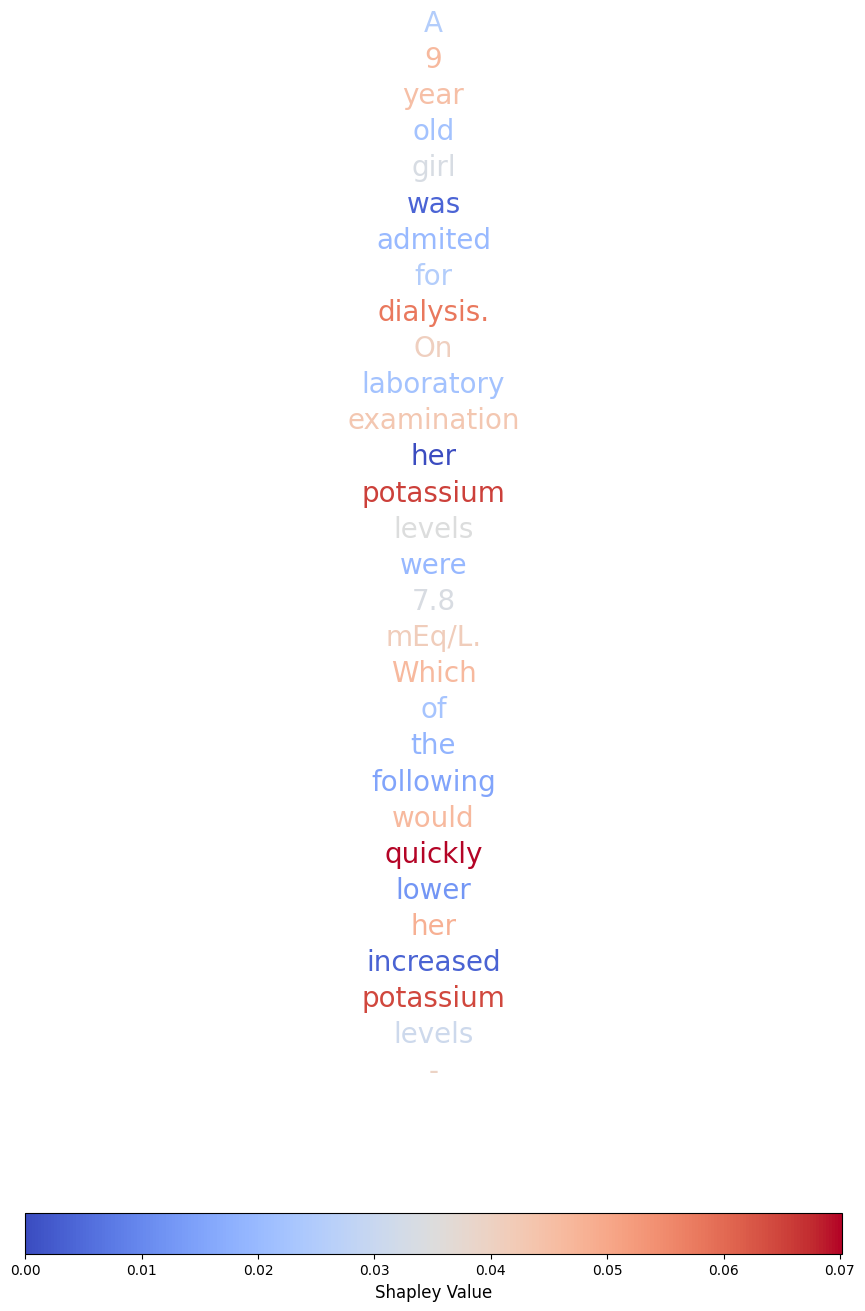

In [90]:
token_shap.plot_colored_text(new_line=True)